In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm


plt.style.use('ggplot')

In [2]:
from versatileorbits import *
import masks

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal


from RealNVP_layer import RealNVP_Layer
import masks

class RealNVP(nn.Module):
    def __init__(self, input_output_size, hidden_size=12, num_layers = 3):
        super(RealNVP, self).__init__()

        self.input_output_size = input_output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #save masks in a parameterlist so they can be saved with the model for reference
        self.masks = nn.ParameterList([nn.Parameter(torch.Tensor(mask), requires_grad=False) for mask in masks.mask2(self.input_output_size, self.num_layers)])

        self.layers = nn.ModuleList([RealNVP_Layer(mask,self.input_output_size,self.hidden_size) for mask in self.masks])


        self.normal_distribution = MultivariateNormal(torch.zeros(self.input_output_size), torch.eye(self.input_output_size))

    def forward(self, x):
        output = x
        log_probability = 0
        for layer in self.layers:
            output, log_det_jacobian = layer(output)
            log_probability += log_det_jacobian
        

        return output, log_probability

    def forward_sample(self, num_samples):
        inputs = self.normal_distribution.sample((num_samples,))
        log_probability = self.normal_distribution.log_prob(inputs)

        outputs = inputs
        for layer in self.layers:
            outputs, log_det_jacobian = layer(outputs)
            log_probability += log_det_jacobian
        

        return outputs, log_probability

    def log_probability(self, y):
        """
        param y: (batch_size, input_output_size) array
        """
        batch_size, _ = y.shape
        log_probability = torch.zeros(batch_size)

        for layer in reversed(self.layers):
            #print("layer, new y =", y[:5])
            y, inverse_log_det_jacobian = layer.inverse(y)
            log_probability += inverse_log_det_jacobian
        
        log_probability += self.normal_distribution.log_prob(y)

        return log_probability

In [5]:
def train(model, num_epochs = 100, batch_size = 64):
    NF_dataset = OrbitsDataset_NF_train(num_samples = 1000, phi0 = 1, H = -0.3, L = 0.5)
    train_loader = torch.utils.data.DataLoader(NF_dataset, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters())
    
    losses = []
    for epoch in tqdm(range(num_epochs)):    
        epoch_loss = 0
        for orbit_position in train_loader:
            log_probability = model.log_probability(orbit_position) #(batch_size)
            loss = - torch.mean(log_probability, dim = 0)
            
            
            loss.backward()
            optimizer.step()
            model.zero_grad()
            
            epoch_loss += loss
            
        
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss.detach())
    
    return model, losses


In [8]:
#model = RealNVP(masks_nf, hidden_size)
model = RealNVP(input_output_size = 4, hidden_size = 32)

model, losses = train(model, num_epochs = 100)

100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


In [9]:
print([loss.item() for loss in losses])

[7.239345550537109, 6.08982515335083, 5.384230136871338, 4.719488620758057, 4.0787034034729, 3.3712711334228516, 2.4376273155212402, 1.7165324687957764, 1.4027608633041382, 1.1697571277618408, 0.9976499080657959, 0.829043447971344, 0.6672244071960449, 0.5105165243148804, 0.393085777759552, 0.3107093274593353, 0.24815785884857178, 0.18740510940551758, 0.13615530729293823, 0.09129209071397781, 0.0475773960351944, 0.009217940270900726, -0.019342321902513504, -0.04836523160338402, -0.07677300274372101, -0.10402199625968933, -0.1278548538684845, -0.14384618401527405, -0.16646260023117065, -0.18402084708213806, -0.19279596209526062, -0.20495909452438354, -0.21886441111564636, -0.22286200523376465, -0.2290320098400116, -0.2333429753780365, -0.23726093769073486, -0.24730370938777924, -0.2571154236793518, -0.2624439597129822, -0.27317380905151367, -0.28379935026168823, -0.29500097036361694, -0.3067329525947571, -0.31953296065330505, -0.32808077335357666, -0.3372946083545685, -0.3420325517654419

In [10]:
outputs, log_probability = model.forward_sample(500)

In [13]:
print(outputs.shape)
print(log_probability[:5])
print(outputs[:5])

torch.Size([100, 4])
tensor([-14.7182, -11.3790, -10.4658, -12.7468, -11.3740],
       grad_fn=<SliceBackward0>)
tensor([[-1.9147, -2.8865,  0.0868,  0.1652],
        [-1.7777, -2.6226, -0.0408, -0.0259],
        [-0.8403, -2.3678,  0.2861,  0.3618],
        [-1.8159, -2.3607, -0.1924, -0.1335],
        [-1.6503, -1.2520, -0.1789, -0.5192]], grad_fn=<SliceBackward0>)


In [11]:
detached_outputs = outputs.detach().numpy()

In [12]:
torch.save(detached_outputs, 'storedTensors/detached_outputs_500.pt')

In [4]:
detached_outputs_load = torch.load('storedTensors/detached_outputs_500.pt')

In [5]:
print(detached_outputs_load[:5,0])

[-1.7415824  -1.4016299  -0.99098194 -1.5554066  -0.4730807 ]


[(-5, 5), (-5, 5)]

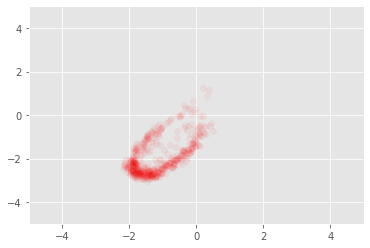

In [8]:
fig, ax = plt.subplots()
ax.scatter(detached_outputs_load[:,0], detached_outputs_load[:,1], alpha=.05, c='red')
ax.set(xlim=(-5, 5), ylim=(-5, 5))

[(-5, 5), (-5, 5)]

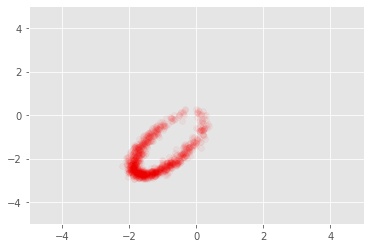

In [7]:
fig, ax = plt.subplots()
train_dataset = OrbitsDataset_NF_train(num_samples = 1000, H = -0.3, L = 0.5, phi0 = 1)   
ax.scatter(train_dataset.data[:,0], train_dataset.data[:,1], alpha=.05, c='red')
ax.set(xlim=(-5, 5), ylim=(-5, 5))